# TIME SERIES ANALYSIS

# Goal: Find outliers, trends and periodicity in the MTA turnstyle data
    

## DATA:
MTA subway fares. It is a complete dataset of
rides logged by card swipes for 600 Manhattan stations.

The data was organized  by Sina Kashuk at CUSP.

It contains 23 different subway card types 
(e.g. monthly pass, daily pass, Act for Disability pass…) as follows:


# Task 1: 
## Event detection: Identify the most prominent event. There is a very significant drop (>3-sigma) in all time series.
## Identify it and figure out what it is due to.


# Task 2: 
## Some of the time series are stationary, some have a complex structure, some show a downward trend: Identify the **ridership types**  that have steadily increased in popularity,  and that have steadily decreased. by how much? (e.g what is the ratio of usage in the first 10 and last 10 weeks)


# Task 3:
## Several stations show a prominent annual periodicity. Identify the 4 **stations** (indentify them by the index of their location in the data cube) that show the most prominent periodic trend on an annual period (52 weeks). (Can you figure out what the periodic peak in rides is due to?)

Populating the interactive namespace from numpy and matplotlib


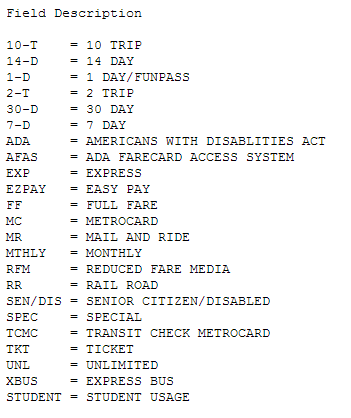

In [8]:
from __future__ import print_function, division
import pylab as pl
import numpy as np
import pandas as pd

%pylab inline

from IPython.display import Image
from IPython.display import clear_output
pl.rcParams['font.size'] = 20
Image(filename = "Ridetypes.png")

This is the information I recieved about the data: "each time series (per station, per ticket type) contains
the number of swipes per week for 194 weeks 
from 05/21/2010 to 02/21/2014. "

The data are available to you as a python data cube here:

you can load it as 

np.load(“MTA_Fare.npy") and 


you will end up with a python numpy array of 
shape (600,23,194)

** note that the missing values are inputted as -1**

if you want to do things like algebra (summing time series for example) you need to take care of that! if you replace the -1 entries with NaN remember to use functions that can deal with nans:
np.nanmean
np.nansum...

# HINTS: 

## When I ask you "what station did somethig", you can sum or average over the ridership types for all station and reduce your data by a factor 23. When I ask you "what ridership type" you can sum or average over the stations and reduce your data by a factor 600! (or even better you could take a weighted average)


# Possibly useful functions

## I used a variety of functions, most of them you are familiar with already. here are a few that you may not have encounvered yet which I used. 
## (But you do not have to use them! there are many ways to do things and you do not have to solve this problem like I did)

* the numpy function np.where() returns the index where a condition is true. it is slow and inefficient but very intuitive and convenient

* the nupy functions np.nansum(), np.sum(), np.nanmean() etc get as parameter an array and the axis along which to sum. If you want to sum over stations, or over rides, you can use these passing the appropriate axis number: axis=1 axis=2...

* to find periodicity you can use fourier transforms. if you choose to use the numpy package you may want to use the real fft function:  np.fft.rfft  
     
     np.fft.rfft(mydata) 
     
     will return the fourier transform, but what you want is its absolute value: np.abs(). Then to get the x axis of your plot in frequency (1/week since the data is in weeks) you can use the function 

     np.fft.rfftfreq(N, p) 
     
     which takes as arguments the length of your time series (the number of datapoints) and the sampling rate: the sampling rate is the inverse of the frequency (in this case, with 1/week sampling, if you want the freq in weeks that is just 1)



In [2]:
# read in data
mta = np.load("MTA_Fare.npy")
#number of time stamps
N = mta.shape[2]

In [71]:
print ("MTA array shape:", mta.shape)
print ("MTA array shape summed over all ride types:", np.nansum(mta,axis=1).shape)

MTA array shape: (600, 23, 194)
MTA array shape summed over all ride types: (600, 194)


create a "ride types" list based on the metadata I was given

In [3]:
#ridership type list
ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'umlim','xbus','stud'])

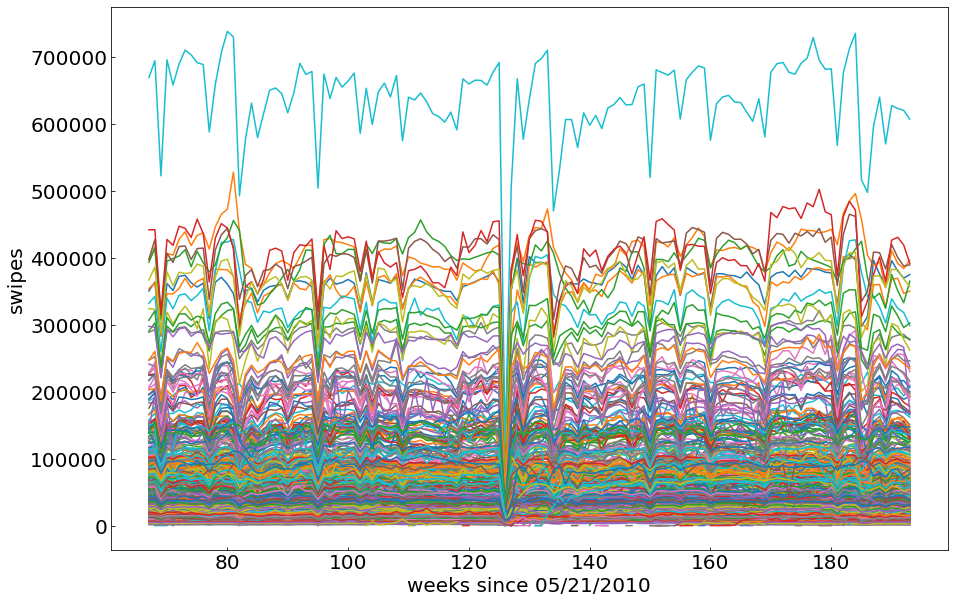

In [10]:
#plot data
pl.figure(figsize=(15,10))
for i in range(mta.shape[0]):
    allrides = [sum(mta[i,:,j]) for j in range(mta.shape[2])]
    pl.plot(allrides)
pl.xlabel("weeks since 05/21/2010", fontsize=20)
tmp = pl.ylabel("swipes", fontsize=20)  

#### Figure 1: time series of MTA weekly subway swipes for 194 weeks starting on 05/23/2010 for all stations, for any ticket type (summed over all ticket types)

In [7]:
#create time range based on metadata
rng = pd.date_range('05/21/2010', periods=N, freq='W')
print ("nominal date range given the metadata\n", rng)

('nominal date range given the metadata\n', DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN'))


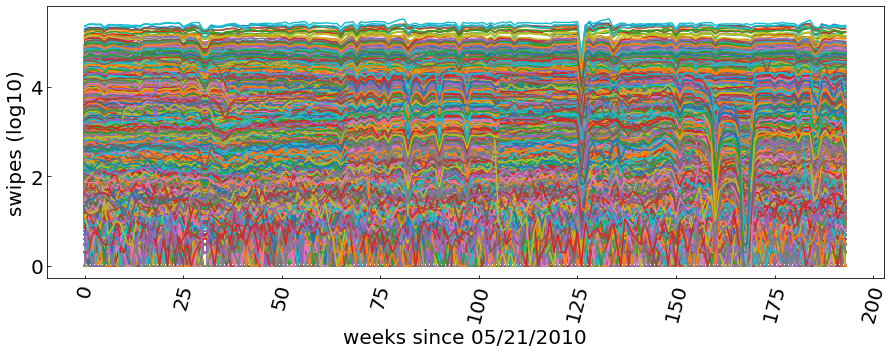

In [9]:
# plot data in log space (may take a while to plot because of the very inefficient double for loop - the counter needs to get to 23)
fig = pl.figure(figsize=(15,5))
ax = fig.add_subplot(111)
mta = mta.astype(float)
mta[mta == -1] = float('NaN')
logrides = np.log10(mta)
for j in range(mta.shape[1]):
    print (j,"/23")
    clear_output(wait=True)
    for i in range(mta.shape[0]):
        pl.plot(logrides[i,j])
pl.xticks(rotation = 75, fontsize=20)
pl.xlabel("weeks since 05/21/2010", fontsize=20)
pl.ylabel("swipes (log10)", fontsize=20)      ;   

#### Figure 2: time series for all ride types and all stations in semi-log space

# 1: event detection 
if the event is in all time series then I can work with the mean, or the sum of the time series to find it. That will smooth over the noise and keep the significance of the event (**if** the event is in all time series!)

In [11]:
mta_allsum = np.nansum(mta, axis=0)
print ("mta array collapsing station axis:", mta_allsum.shape)
mta_allsum = np.nansum(mta_allsum, axis=0)
print ("mta array collapsing ride type and station axes:", mta_allsum.shape)

mta array collapsing station axis: (23, 194)
mta array collapsing ride type and station axes: (194,)


In [12]:
#need to convert to use datetime index w fill_between (pandas 0.21) >0.21)
d = [pd.Timestamp(x).to_pydatetime() for x in rng]

Find the most significant event by 3-sigma thresholding 

3 sigma threshold 20829468.6
outlier index (array([126]),)
outlier date DatetimeIndex(['2012-10-21'], dtype='datetime64[ns]', freq=None)


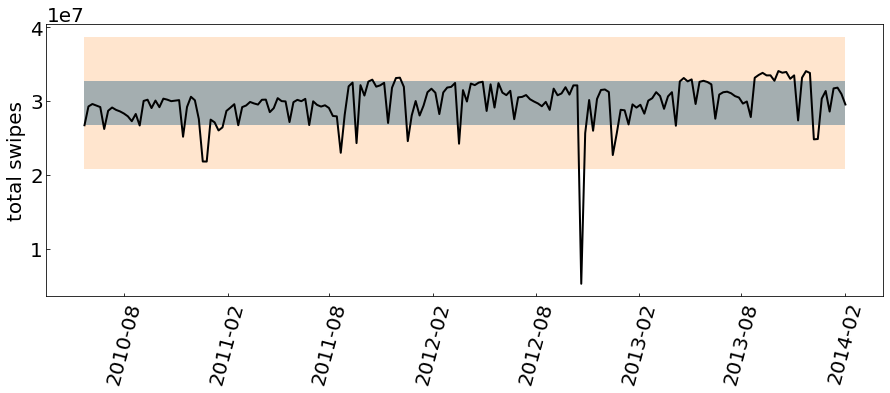

In [14]:
#plot all swipes
pl.figure(figsize=(15,5))
onesig = np.std(mta_allsum)
tsthresh = np.nanmean(mta_allsum)  - 3 * onesig
print ("3 sigma threshold %.1f"%tsthresh)
print ("outlier index", np.where(mta_allsum < tsthresh))
print ("outlier date", rng[np.where(mta_allsum < tsthresh)])
pl.fill_between(d, np.nanmean(mta_allsum) - onesig,
                np.nanmean(mta_allsum) + onesig, alpha=0.5)
pl.fill_between(d, np.nanmean(mta_allsum) - 3 * onesig,
                 np.nanmean(mta_allsum) + 3 * onesig, alpha = 0.2)
#pl.fill_between(weighted +threesigma(weighted , 10), weighted -threesigma(weighted 
pl.plot(d, mta_allsum, 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  ;


#### Figure 3a: The sum of all MTA swipe time series, and the three- and one-sigma thresholds indicated as shaded regions

# The outlier is near the date of sandy, but I am off by a week. I will reset the range accordingly

first day  2010-05-30
outlier date 2012-10-28


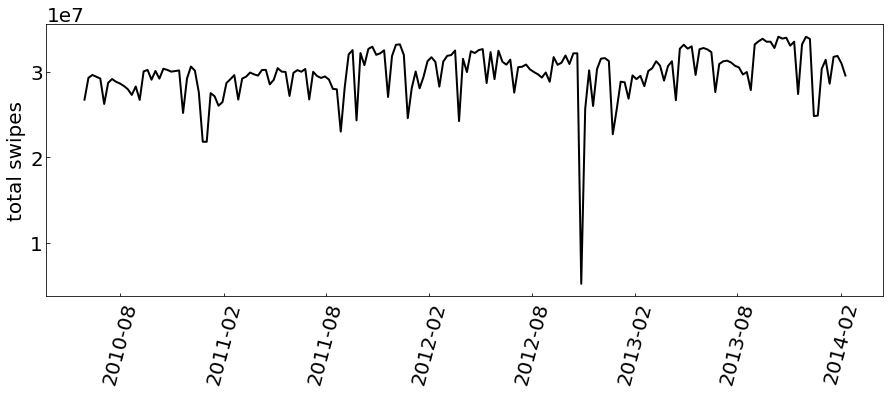

In [18]:
rng = pd.date_range('05/29/2010', periods=N, freq='W')
#need to convert to use datetime index w fill_between (pandas 0.21) >0.21)
d = [pd.Timestamp(x).to_pydatetime() for x in rng]#plot all swipes
print ("first day ", d[0].date())
pl.figure(figsize=(15,5))
pl.plot(rng, mta_allsum, 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
print ("outlier date", rng[np.where(mta_allsum < tsthresh)][0].date())

#### Figure 3b:  Sum of all MTA swipe time series, with corrected timeline: the time range covers 194 weeks starting on 2010-05-30 as confirmed by the most significant drop in ridership aligning with Hurricane Sandy, in the week of 2012-10-28, when MTS shut down for several days.

A  more representative way to show this is to plot the weighted average of all rides, weighted by ticket popularity

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


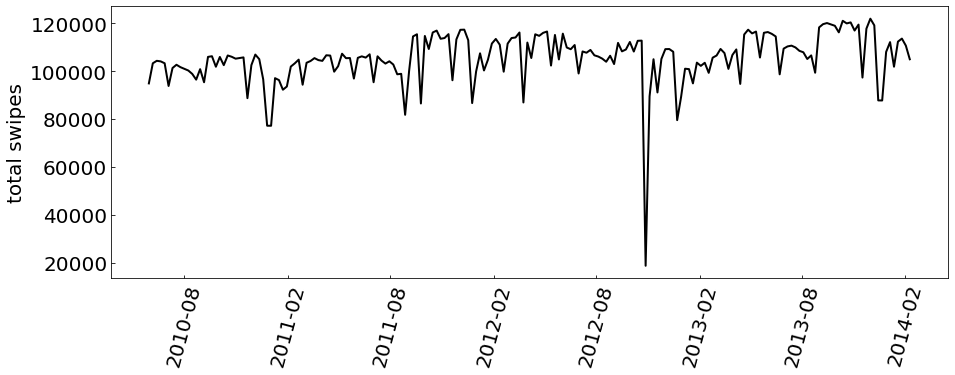

In [19]:
weightedrides = np.zeros((mta.shape[0], mta.shape[2]))

for i in range(mta.shape[0]):
    allrides = np.array([np.nansum(mta[i,:,j].flatten()) for j in range(mta.shape[2])])
    #print (allrides/nanmean(allrides)).shape, weightedrides.shape
    weightedrides[i] = allrides / np.sqrt(nanmean(allrides))
    #pl.plot(rng, np.log10(weightedrides[i]))
    #pl.xticks(rotation = 75)

    
#plot weighted by station, per ride
pl.figure(figsize=(15,5))
pl.plot(d, np.nansum(weightedrides, axis=0), 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
rides = pd.DataFrame({'t':rng, 'ridecounts':np.nansum(weightedrides, axis=0)})

#### Figure 3: time series for all rides weighted by mean number of rides per ticket type in semi-log space

 # 2: finding trends

### find the ride type that has the steepest increase, and the steepest decrease. notice: we are looking ofr something that has a more or less constant trend

## to do this you can sum or average (a weighted average is probably best) over all stations, leaving you with 23 time series, one per type. 

## you can use a rolling mean for smoothing, you can use the ratio of the number of swipes near the beginning and the end if the time series, or fit a line to the time series and get its slope.  find series with the steepest upward trend, and the steepest downward trend.

## notice that you should inspect the time series, either algorithmically or by eye, to ensure you see a trend, and not just changing structure.


Since I am asked to find which ticket type has a steady increase in popularity, I will use the average across all stations

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


stdev 546777.62, fractional increase over time 1.05: 
stdev 64593.90, fractional increase over time 1.33: 
stdev 5767.41, fractional increase over time 1.17: 
stdev 8828.00, fractional increase over time 0.97: 
stdev 3624.09, fractional increase over time 1.07: 
stdev 631955.02, fractional increase over time 1.46: 
stdev 473487.37, fractional increase over time 0.92: 
stdev 3794.93, fractional increase over time 0.00: 
stdev 101444.89, fractional increase over time 0.00: 
stdev 206370.78, fractional increase over time 0.00: 
stdev 18800.95, fractional increase over time 0.87: 
stdev 25371.32, fractional increase over time 1.23: 
stdev 61154.07, fractional increase over time 26332.33: 
stdev 17282.83, fractional increase over time 0.60: 
stdev 153165.98, fractional increase over time 0.65: 
stdev 33309.14, fractional increase over time 2.64: 
stdev 18139.76, fractional increase over time 2.94: 
stdev 10350.80, fractional increase over time 76.86: 
stdev 30841.45, fractional increase ove

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:19: RuntimeWarning: divide by zero encountered in double_scalars


stdev 587158.97, fractional increase over time inf: 


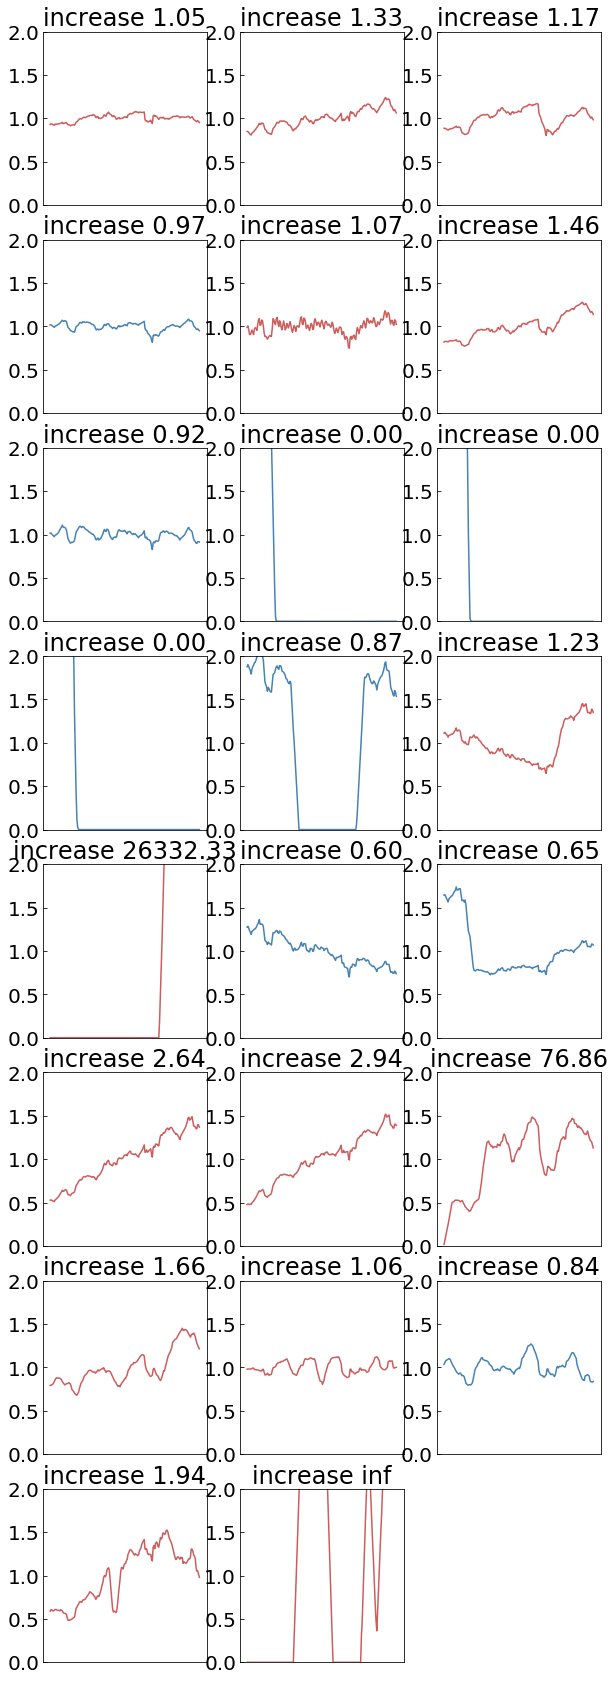

In [31]:
#remove series w bad data and store the rest in a new array
mtanew = np.empty_like(mta)
for i,m in enumerate(mta):
    for j,t in enumerate(m):
        if not -1 in t:
            mtanew[i][j] = t
mta = mtanew

increase = np.zeros((mta.shape[1],2))
fig = pl.figure(figsize=(10,30))


for i in range(mta.shape[1]):
    mta_allsum = mta[:,i,:]
    ax = fig.add_subplot(8,3,i+1)
    #rolling mean of rides by type
    thisride = pd.rolling_mean(np.nansum(mta_allsum, axis=0), 10)
    increase[i] = np.array([np.nanstd(thisride), 
                   np.nanmean(thisride[-10:]) / np.nanmean(thisride[:10])])
    print ("stdev {0:.2f}, fractional increase over time {1:.2f}: ".format(increase[i][0], 
                                                                            increase[i][1]))
    if increase[i][1] > 1:
        pl.plot(thisride / np.nanmean(thisride), color="IndianRed")
    else: 
        pl.plot(thisride / np.nanmean(thisride), color="SteelBlue")
    pl.ylim(0,2)
    pl.xticks([])
    pl.title("increase %.2f"%(increase[i][1]))
        


#### Figure 4a: time series smoothed (rolling mean w window 10), normalized,  in semi-log space. In red are possibly increasing trends (ratio of beginning to end of the time series >1)

order of increasing trend magnitude: [22 12 17 16 15 21 18  5  1 11  2  4 19  0  3  6 10 20 14 13  7  8  9]
corresponding stdev: [  5.87158972e+05   6.11540734e+04   1.03507976e+04   1.81397619e+04
   3.33091354e+04   2.52041044e+02   3.08414543e+04   6.31955018e+05
   6.45939014e+04   2.53713236e+04   5.76741249e+03   3.62408853e+03
   1.57054061e+03   5.46777617e+05   8.82800386e+03   4.73487373e+05
   1.88009465e+04   6.81416737e+02   1.53165984e+05   1.72828339e+04
   3.79492677e+03   1.01444892e+05   2.06370776e+05]


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: FutureWarning: pd.rolling_mean is deprecated for ndarrays and will be removed in a future version


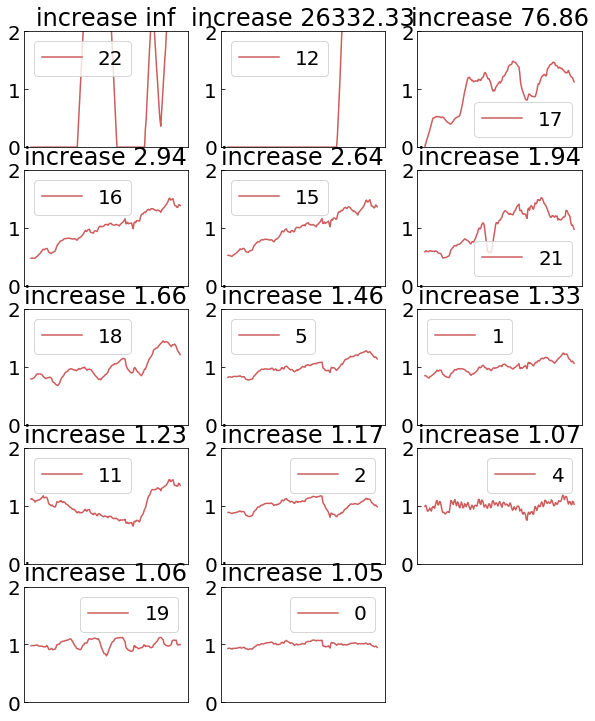

In [35]:
#printing the increase sorted
fig = pl.figure(figsize=(10,20))
trendsort = np.argsort(increase[:,1])[::-1]
print ("order of increasing trend magnitude:", trendsort)
print ("corresponding stdev:", increase[trendsort,0])
for j, i in enumerate(trendsort):
    mta_allsum = mta[:,i,:]
    thisride = pd.rolling_mean(np.nansum(mta_allsum, axis=0), 10)
    if increase[i][1] > 1:
        ax = fig.add_subplot(8,3,j+1)
        pl.plot(thisride / np.nanmean(thisride), color="IndianRed", label="%d"%i)
    else: 
        continue
    pl.ylim(0,2)
    pl.title("increase %.2f"%(increase[i][1]))
    pl.legend()
        
    pl.xticks([])


#### Figure 4b: As Figure 4a, but only the time series with increasing trends are plotted, in descending order of increase magnitude (caluclated as ratio of beginning to end of the time series averaged over 10 time stapms)

# if my data is small ~20 time series, why not just looking at it! (think about the assigned reading) 
# the first smooth trend is for ride type at index 16 (by visual inspection)

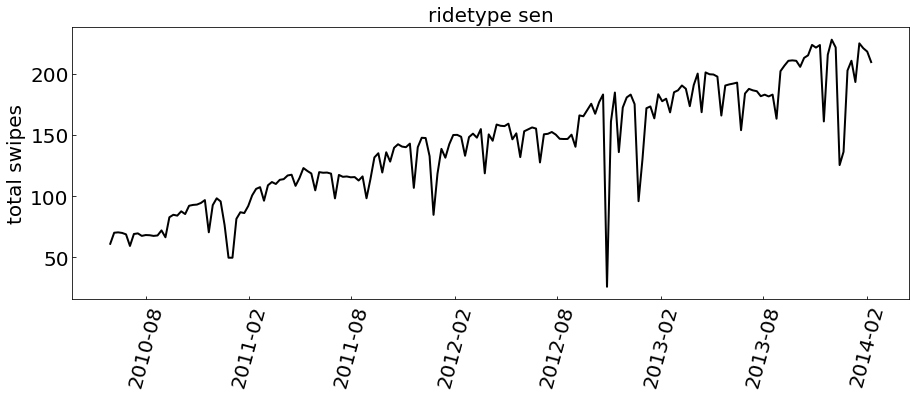

In [23]:
# plot the most evident trend: senior tickets
mtabyride = np.nanmean(mta, axis=0)
pl.figure(figsize=(15,5))
pl.plot(d, mtabyride[16], 'k-', lw = 2)
pl.xticks(rotation = 75, fontsize=20)
pl.ylabel("total swipes", fontsize=20)  
title = pl.title ("ridetype " + ridetype[16], fontsize=20)

#### Figure 4c: the steepest smooth increase in ridership type is for Senior passes. Above is the average over all station of the senior pass popularity

In [36]:
# a more rigorous way to find the most significant, smooth increasing trend, is by fitting a line to the data
import statsmodels.api as sm
from statsmodels.stats.gof import chisquare
models = []
selectedIndeces = [17,16,15]
for i in selectedIndeces:
    models.append(sm.OLS(mtabyride[i], 
                         sm.add_constant(np.arange(mta.shape[2]))).fit())
    #(np.nanmean(mta, axis=0)[16])
for i,m in enumerate(models):
    print (selectedIndeces[i], "R^2 line fit %.2f"%m.rsquared)

17 R^2 line fit 0.48
16 R^2 line fit 0.82
15 R^2 line fit 0.80


# the fit to a straight line is best for index 16 as well, confirming that Senior rides have the steepest continuous increase among ride types 

# 3: Find periodicity
Here I am asked to find periodicity on any time series, so I will us time series averaged over ridership type 

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:11: RuntimeWarning: divide by zero encountered in double_scalars


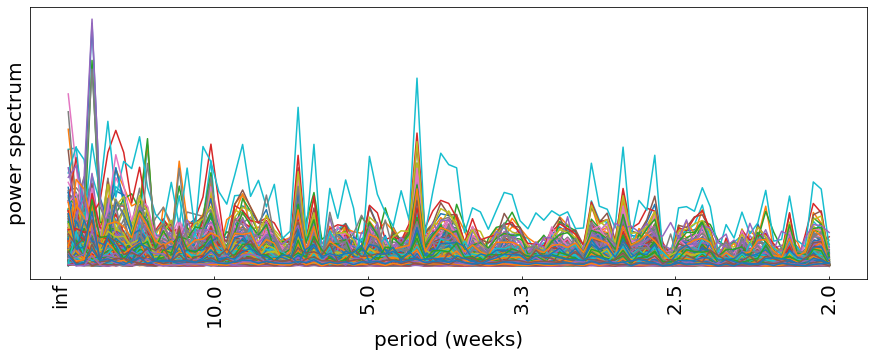

In [39]:
#average by ridership type and plot the power spextrum
mtabystation = np.nanmean(mta, axis=1)
fig = pl.figure(figsize = (15,5))
ax = fig.add_subplot(111)
freqs = np.fft.rfftfreq(N, 1.0)
this_ffts =  np.array([np.abs(np.fft.rfft(mtabystation[i])) 
                       for i in range(mta.shape[0])])
for this_fft in this_ffts:
    ax.plot(freqs[1:], (this_fft[1:]))
allperiods = [1.0/N, 1./104, 1.0/52, 1.0/26, 1.0/13, 1.0/8, 1.0/4, 1.0/2]
ax.set_xticklabels([ "%.1f"%(1/f) for f in ax.get_xticks()], rotation=90, fontsize=20)
ax.set_yticks([])
pl.xlabel("period (weeks)", fontsize=20)
pl.ylabel("power spectrum");


#### Figure 5a: Power spectrum of  rides for all stations

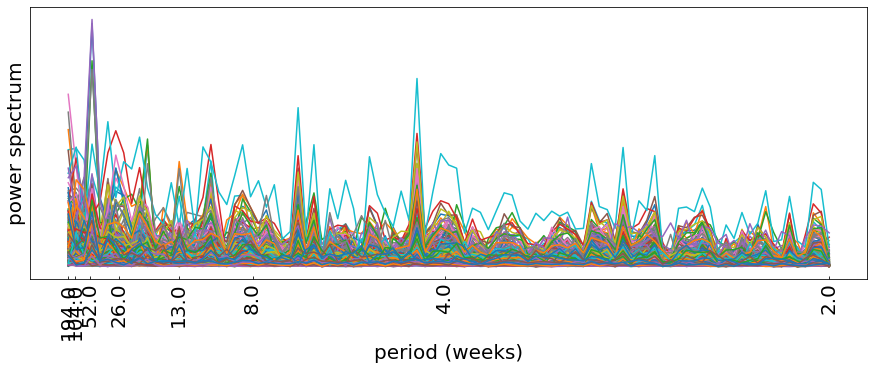

In [42]:
#plotting with a more informative set of x labels
fig = pl.figure(figsize = (15,5))
ax = fig.add_subplot(111)
this_ffts =  np.array([np.abs(np.fft.rfft(mtabystation[i]))
                       for i in range(mta.shape[0])])
for this_fft in this_ffts:
    ax.plot(freqs[1:],(this_fft[1:]))
allperiods = [1.0/194, 1./104, 1.0/52, 1.0/26, 1.0/13, 1.0/8, 1.0/4, 1.0/2]
ax.set_xticks (allperiods)
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90, fontsize=20)
ax.set_yticks([])
pl.xlabel("period (weeks)", fontsize=20)
pl.ylabel("power spectrum");


#### Figure 5b: As figure 5, with more informative labeling of the x axis

In [40]:
# finding index of periodicity of 1 year
yearindex = np.where(np.abs(freqs - 1.0/52) == min(np.abs(freqs - 1.0/52)))[0]
print ("index of frequency closest to %.1f weeks (%.1f)"%(1.0/freqs[yearindex], yearindex))


index of frequency closest to 48.5 weeks (4.0)


In [47]:
#52 weeks (or close to that) is the 4th cell of the fourier transform array. 
#I am sorting by the power in that cell and taking the indeces of the sorted array 
#(that is what argsort returns)
yearly_sorted =  np.array(this_ffts).T[4].argsort()
yearly_sorted = yearly_sorted[~np.isnan(np.array(this_ffts)[yearly_sorted[:],4])]
#printing the 4 time series with strongest annual periodic trend
yearly_sorted[-4:][::-1]

array([194, 150,  32, 327])

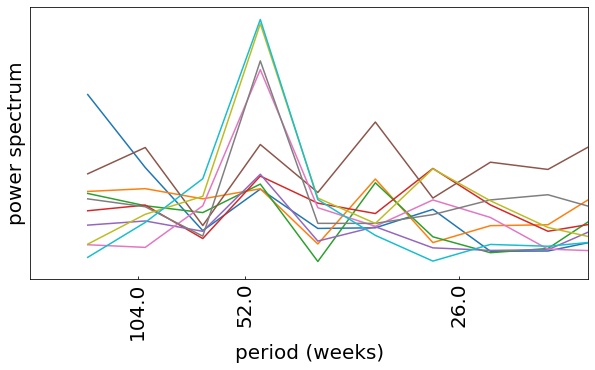

In [44]:
#finding lightcures with periodicity that peak near 1 year 
fig = pl.figure(figsize = (10,5))
ax = fig.add_subplot(111)



#print np.array(this_ffts)[yearly_sorted[-20:]]
for this_fft in np.array(this_ffts)[yearly_sorted[-10:]]:
    ax.plot(np.fft.rfftfreq(N, 1.0)[1:],(this_fft[1:]))

allperiods = [1./104, 1.0/52, 1.0/26]
ax.set_xlim(0,0.05)
ax.set_xticks (allperiods)
ax.set_yticks ([])
ax.set_xticklabels([ "%s"%(1/f) for f in allperiods], rotation=90, fontsize=20)
pl.xlabel("period (weeks)", fontsize=20)
pl.ylabel("power spectrum");


#### Figure 5c: As figure 5b, but  zoomed-in of the power spectra of riderships for all stations around the 1-year periodicity region

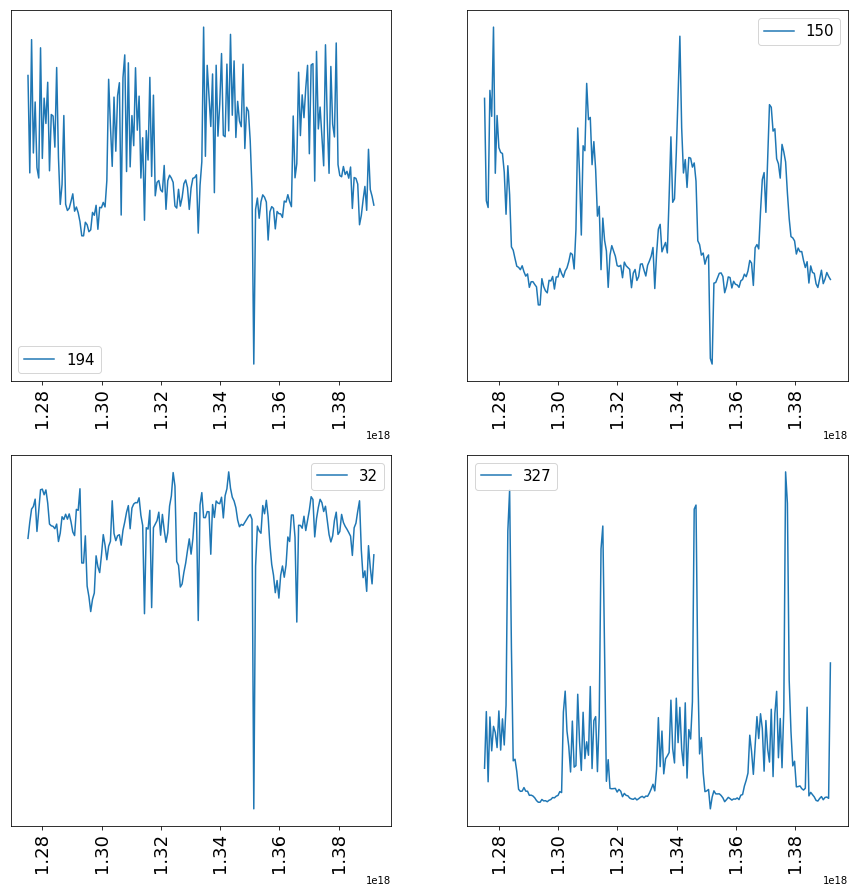

In [90]:
#plotting top 4 annually-periodic time series
fig = pl.figure(figsize=(15,15))
for i,j in enumerate(yearly_sorted[-1:-5:-1]):
    
    ax = fig.add_subplot(2,2,i+1)
    ax.plot(rng, weightedrides[j], label="%d"%j)
    pl.legend(fontsize = 15)
    ax.set_yticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(18) 
        tick.label.set_rotation('vertical')


### Figure 6: The 4 station that shows the most clear periodicity at 1-year: their indices are (in order of decreasing strength in the periodicity) 194, 150, 32, and 327

# 4: Clustering time series

this is very vanilla clustering

1) use KMeans

2) random cluster centers

3) arbitrary choice in the number of clusters

here I am working with all time series, regardless of station or ritership type. 

I will reshape the array
600 x 23 x 194 -> (600*23) x 194 = 9317 x 194

In [49]:
from sklearn.cluster import KMeans
#clustering in 9 clusters - this seemed a good solution by visual inspection of tthe clusters. 
#later I will validate it with a silouette plot

nc = 9
data = np.load("MTA_Fare.npy")

tots = data.transpose(2,0,1).reshape(data.shape[2], 
                                     data.shape[1]*data.shape[0]).T
# remove null time series
tots = tots[tots.std(1)>0]

km = KMeans(n_clusters=nc)

#standardizing before clustering
vals = ((tots.T - tots.mean(1))/tots.std(1)).T

km.fit(vals)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=9, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

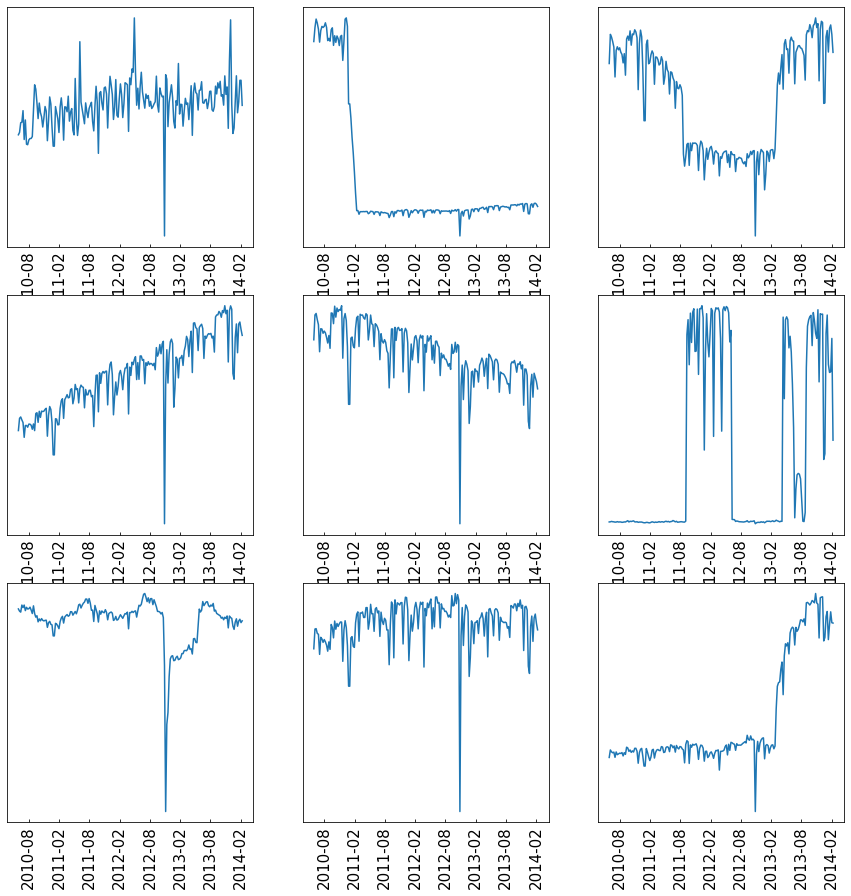

In [50]:
fig = pl.figure(figsize=(15,15))
for i,cc in enumerate(km.cluster_centers_):
    ax = fig.add_subplot(3,3,i+1)
    ax.plot(rng, cc)
    ax.set_yticks([])
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(15) 
        tick.label.set_rotation('vertical')

#### Figure 7: K-means cluster centers (9 clusters) with random start points for all rides by type and station

In [51]:
for lab in set(km.labels_):
    print ('there are ', sum(km.labels_==lab), "time series in cluster", lab)


there are  945 time series in cluster 0
there are  1737 time series in cluster 1
there are  842 time series in cluster 2
there are  1781 time series in cluster 3
there are  733 time series in cluster 4
there are  457 time series in cluster 5
there are  482 time series in cluster 6
there are  1171 time series in cluster 7
there are  1169 time series in cluster 8


In [52]:
distance = (np.array([vals - km.cluster_centers_[i]
                      for i in range (len(km.cluster_centers_))])**2)
for lab in set(km.labels_):
    print ("for cluster ", lab, "the average distance to the center is %.2f"\
           %np.mean(distance[lab][km.labels_==lab]))


for cluster  0 the average distance to the center is 0.98
for cluster  1 the average distance to the center is 0.15
for cluster  2 the average distance to the center is 0.41
for cluster  3 the average distance to the center is 0.35
for cluster  4 the average distance to the center is 0.54
for cluster  5 the average distance to the center is 0.05
for cluster  6 the average distance to the center is 0.67
for cluster  7 the average distance to the center is 0.53
for cluster  8 the average distance to the center is 0.27


In [59]:
vals.shape

(9317, 194)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


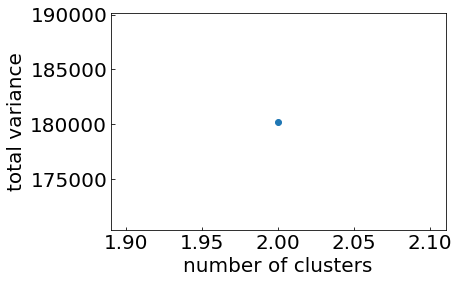

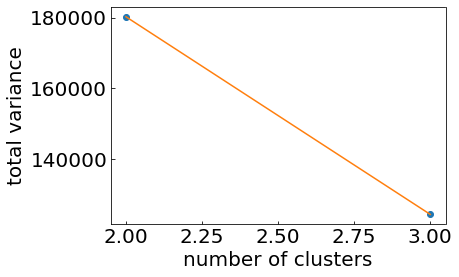

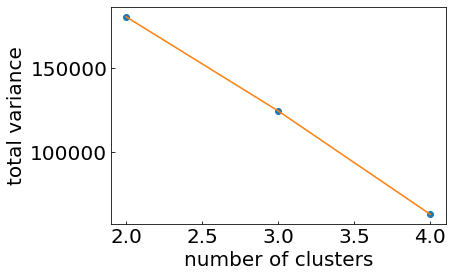

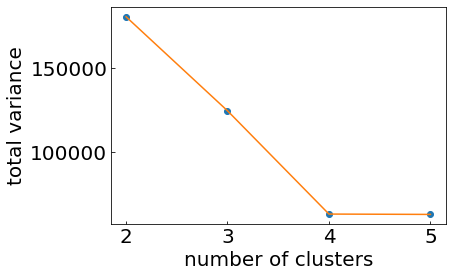

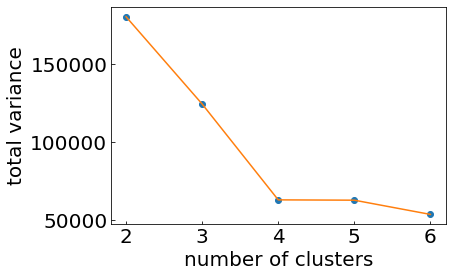

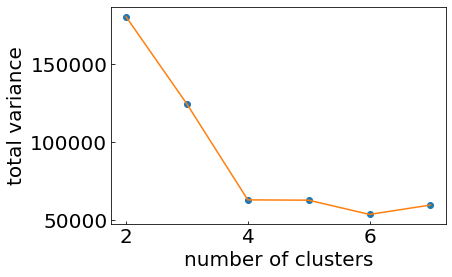

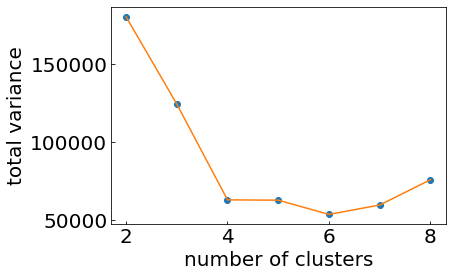

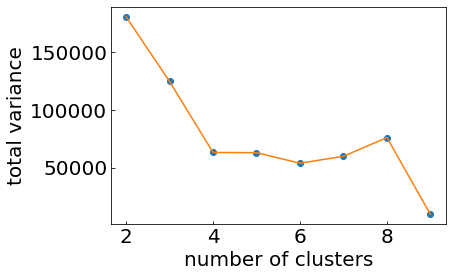

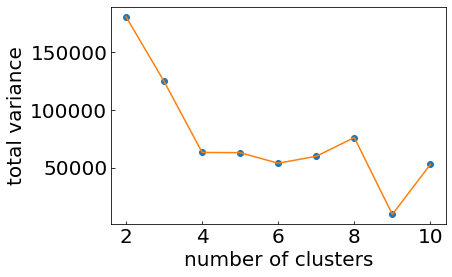

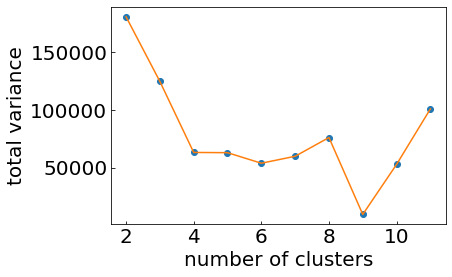

In [77]:
vs = []
for nc in range(2, 12):

    km = KMeans(n_clusters=nc)

    km.fit(vals)
    labels = km.fit_predict(vals)
    vs.append(np.sum(
            np.array(
                [np.nansum(np.sqrt(vals[labels==1] - km.cluster_centers_[l]))])))
    
    pl.plot(range(2, nc + 1), vs, 'o')
    pl.plot(range(2, nc + 1), vs, '-')
    pl.ylabel("total variance")
    pl.xlabel("number of clusters")
   
    pl.show();

#### Figure 8: silouette plots for the clustering of MTA time series: the total variance is minimized by clustering, so it is technically bound to decrease with increasing number of clusters, but due to the random initialization of the cluster centers the variance can increase from run to run even with a larger number of clusters. The right number of clusters as indicated by this plot, is 4. A second dip is visible at 9 clusters, which is the number of clusters I choose. 